In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# --- 1. Data Setup ---


excel_file_path = 'data_grades_exams_PaS24_English.xlsx' # <--- CHANGE THIS TO YOUR FILE PATH

try:
    # Attempt to read the Excel file
    # Specify the sheet name if it's not the first one, e.g., sheet_name='Sheet1'
    df = pd.read_excel(excel_file_path)
    print(f"Successfully loaded data from '{excel_file_path}'.")
    print("Shape of the loaded data:", df.shape)
    print("First 5 rows:\n", df.head())

except FileNotFoundError:
    print(f"Error: The file '{excel_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
print("--- Step 1: Setting up initial data ---")



# --- 2. Preprocessing & Training for Model 1 (SVR for Mid + Etc) ---
print("--- Step 2: Training Model 1 (SVR for Midterm + Other work) ---")
# This section calculates the score minus the final exam and percentile ranks.
df_model1 = df.copy()
prefixes = ["EM", "DM", "LA", "PAS"]

for prefix in prefixes:
    df_model1[f"{prefix}_score_minus_final"] = df_model1[f"{prefix}_score"] - df_model1[f"{prefix}_final"]

# Capture the min and max of the target column BEFORE scaling for later use
pas_mid_etc_min = df_model1["PAS_score_minus_final"].min()
pas_mid_etc_max = df_model1["PAS_score_minus_final"].max()

# Scale the data
scaler_model1 = MinMaxScaler()
# We only need to scale the columns we will use
cols_to_scale_m1 = [f"{p}_score_minus_final" for p in prefixes]
df_model1[cols_to_scale_m1] = scaler_model1.fit_transform(df_model1[cols_to_scale_m1])

# Calculate percentile rank features
target_col_m1 = "PAS_score_minus_final"
features_m1 = []
for prefix in ["EM", "DM", "LA"]:
    features_m1.append(f"{prefix}_score_minus_final")
    df_model1[f"{prefix}_mid_pct_rank"] = df_model1[f"{prefix}_mid"].rank(pct=True)
    df_model1[f"{prefix}_final_pct_rank"] = df_model1[f"{prefix}_final"].rank(pct=True)
    features_m1.append(f"{prefix}_mid_pct_rank")
    features_m1.append(f"{prefix}_final_pct_rank")

# Define training data and train the SVR model
X1 = df_model1[features_m1].values
y1 = df_model1[target_col_m1].values

svr_model = SVR(C=100.0, epsilon=0.1, gamma=0.01, kernel='rbf')
svr_model.fit(X1, y1)
print("Model 1 (SVR) trained successfully.\n")


# --- 3. Preprocessing & Training for Model 2 (Linear Regression for Final Exam) ---
print("--- Step 3: Training Model 2 (Linear Regression for Final Exam) ---")
# This section calculates the student's average difference feature.
df_model2 = pd.DataFrame()
for prefix in prefixes:
    df_model2[f"{prefix}_mid"] = df[f"{prefix}_mid"]
    df_model2[f"{prefix}_final"] = df[f"{prefix}_final"]

# Capture min and max of PAS_final BEFORE scaling
pas_final_min = df_model2["PAS_final"].min()
pas_final_max = df_model2["PAS_final"].max()

scaler_model2 = MinMaxScaler()
df_model2_scaled = pd.DataFrame(scaler_model2.fit_transform(df_model2), columns=df_model2.columns)

df_model2_scaled['EM_diff'] = df_model2_scaled['EM_final'] - df_model2_scaled['EM_mid']
df_model2_scaled['DM_diff'] = df_model2_scaled['DM_final'] - df_model2_scaled['DM_mid']
df_model2_scaled['LA_diff'] = df_model2_scaled['LA_final'] - df_model2_scaled['LA_mid']
df_model2_scaled['student_overall_avg_diff'] = df_model2_scaled[['EM_diff', 'DM_diff', 'LA_diff']].mean(axis=1)

# Create the stacked dataset for training
X2_stacked = pd.concat([
    df_model2_scaled[['EM_mid', 'student_overall_avg_diff']].rename(columns={'EM_mid': 'midterm_score'}),
    df_model2_scaled[['DM_mid', 'student_overall_avg_diff']].rename(columns={'DM_mid': 'midterm_score'}),
    df_model2_scaled[['LA_mid', 'student_overall_avg_diff']].rename(columns={'LA_mid': 'midterm_score'})
], ignore_index=True)
y2_stacked = pd.concat([
    df_model2_scaled['EM_final'],
    df_model2_scaled['DM_final'],
    df_model2_scaled['LA_final']
], ignore_index=True)

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X2_stacked.values, y2_stacked.values)
print("Model 2 (Linear Regression) trained successfully.\n")


# --- 4. Generate Predictions for PAS and Combine ---
print("--- Step 4: Generating and Combining Predictions for PAS ---")
# Predict Component 1: Midterm + Other work score (scaled)
predicted_mid_etc_scaled = svr_model.predict(df_model1[features_m1].values)

# Predict Component 2: Final exam score (scaled)
# We need to use the PAS midterm score and the average difference to predict the PAS final
X_pred_final = df_model2_scaled[['PAS_mid', 'student_overall_avg_diff']].values
predicted_final_scaled = lr_model.predict(X_pred_final)

# Un-scale the predictions to get the real score values
predicted_mid_etc = predicted_mid_etc_scaled * (pas_mid_etc_max - pas_mid_etc_min) + pas_mid_etc_min
predicted_final = predicted_final_scaled * (pas_final_max - pas_final_min) + pas_final_min

# The final total score is the sum of the two predicted components
df['PAS_total_score_predicted'] = predicted_mid_etc + predicted_final
print("Final PAS scores predicted and combined.\n")


# --- 5. Display Final Results ---
print("--- Final Result ---")
print("A snippet of the DataFrame with the original and predicted PAS scores:")
print(df[['PAS_score', 'PAS_total_score_predicted']].head())

# Optional: You can check the summary stats to see how they compare
print("\nDescriptive statistics for original vs. predicted scores:")
print(df[['PAS_score', 'PAS_total_score_predicted']].describe())

Successfully loaded data from 'data_grades_exams_PaS24_English.xlsx'.
Shape of the loaded data: (262, 19)
First 5 rows:
    #  PAS_final  PAS_mid  PAS_score PAS_grade  EM_final  EM_mid  EM_score  \
0  1       33.0     17.5  56.410000        B+         2     2.0      30.4   
1  2       21.0      0.0  24.121538        D0         0     1.0       6.0   
2  3       32.0      3.0  62.525385        A0        13    14.0      49.0   
3  4       23.4      3.5  32.848462        D+         0     4.0      12.5   
4  5       26.2      7.0  56.084615        B+        14    10.0      39.5   

  EM_grade  LA_final  LA_mid  LA_score LA_grade  DM_final  DM_mid  DM_score  \
0       C0         0       7     22.07       D0         0       4     10.90   
1        F         1       3     27.50        F         5       4     21.89   
2       B0        31      11     64.67       B+        32      10     59.86   
3        F         2       4     18.03       D0         9       8     25.21   
4       C+        14 


--- Step 6: Visualizing the Results ---
Generating Swarm Plot...


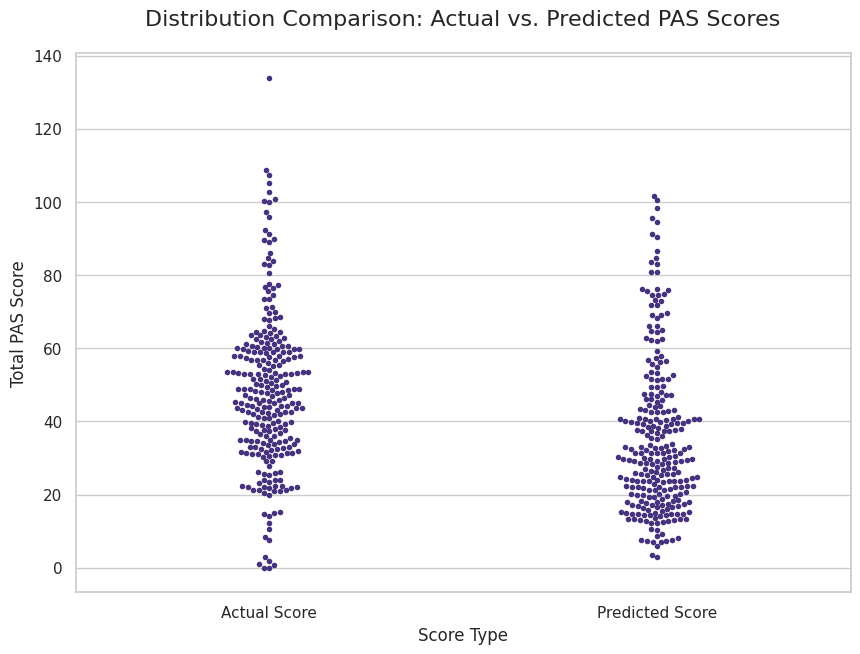

Generating Scatter Plot...


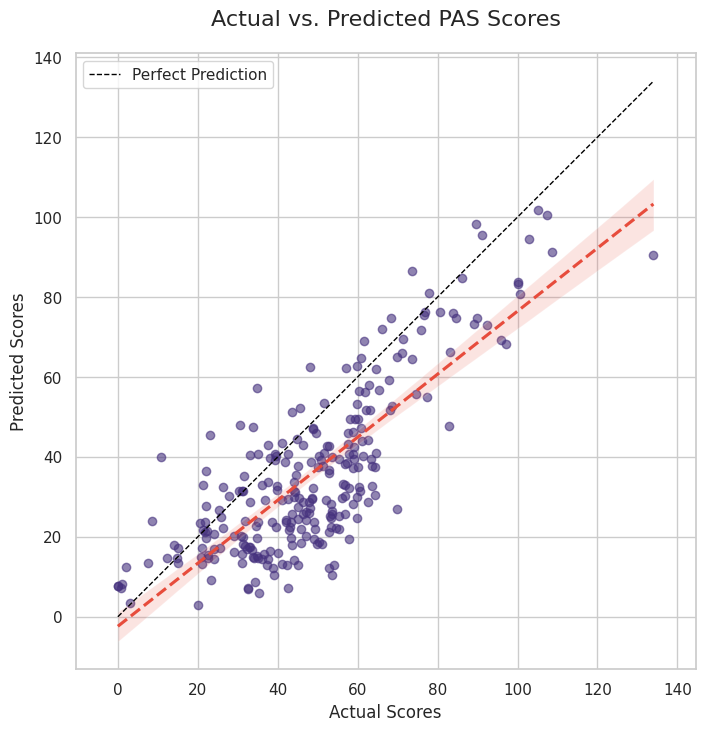

Generating Residual Plot...


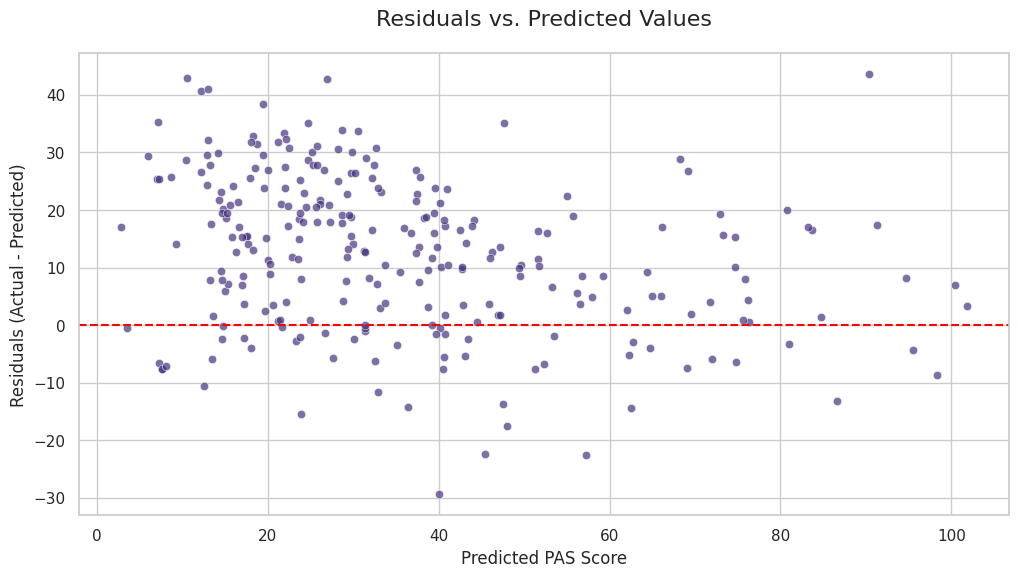


--- Analysis of Linear Regression Model 2 Coefficients ---
Intercept: 0.0595
Coefficients (for 'midterm_score' and 'student_overall_avg_diff'): [0.85196082 0.9823935 ]


In [ ]:
# --- 6. Visualizing the Results ---
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Step 6: Visualizing the Results ---")

# Set a pleasant plot style for clarity
sns.set_theme(style="whitegrid", palette="viridis")

# --- Visualization 1: Swarm Plot of Actual vs. Predicted Scores ---
# This plot shows the distribution of each individual data point. It's great for
# seeing the density and spread of scores.
print("Generating Swarm Plot...")
plt.figure(figsize=(10, 7))

# We need to create a long-form DataFrame suitable for seaborn plots
plot_df = pd.DataFrame({
    'Score': np.concatenate([df['PAS_score'], df['PAS_total_score_predicted']]),
    'Type': ['Actual Score'] * len(df) + ['Predicted Score'] * len(df)
})

sns.swarmplot(x='Type', y='Score', data=plot_df, size=4)
plt.title('Distribution Comparison: Actual vs. Predicted PAS Scores', fontsize=16, pad=20)
plt.xlabel('Score Type', fontsize=12)
plt.ylabel('Total PAS Score', fontsize=12)
plt.show()


# --- Visualization 2: Scatter Plot for Direct Comparison ---
# This is a classic regression evaluation plot. The closer the points are to the
# red dashed line, the more accurate the prediction.
print("Generating Scatter Plot...")
plt.figure(figsize=(8, 8))

sns.regplot(x='PAS_score', y='PAS_total_score_predicted', data=df,
            scatter_kws={'alpha':0.6}, line_kws={'color': '#e74c3c', 'linestyle':'--'})

# Add a line for perfect prediction (y=x) for reference
max_val = max(df['PAS_score'].max(), df['PAS_total_score_predicted'].max())
min_val = min(df['PAS_score'].min(), df['PAS_total_score_predicted'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='Perfect Prediction')

plt.title('Actual vs. Predicted PAS Scores', fontsize=16, pad=20)
plt.xlabel('Actual Scores', fontsize=12)
plt.ylabel('Predicted Scores', fontsize=12)
plt.legend()
plt.axis('equal') # Ensures the x and y axes have the same scale
plt.grid(True)
plt.show()


# --- Visualization 3: Residual Plot ---
# This plot helps check for bias in the model's errors. Ideally, the points
# should be randomly scattered around the horizontal line at zero, with no
# discernible pattern.
print("Generating Residual Plot...")
df['residuals'] = df['PAS_score'] - df['PAS_total_score_predicted']

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PAS_total_score_predicted', y='residuals', data=df, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values', fontsize=16, pad=20)
plt.xlabel('Predicted PAS Score', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.show()

print("\n--- Analysis of Linear Regression Model 2 Coefficients ---")
# These coefficients tell us what the linear model learned.
# The first coefficient is for 'midterm_score' (scaled).
# The second coefficient is for 'student_overall_avg_diff' (scaled).
print(f"Intercept: {lr_model.intercept_:.4f}")
print(f"Coefficients (for 'midterm_score' and 'student_overall_avg_diff'): {lr_model.coef_}")



Generating Swarm Plot of Score Differences...


<ipython-input-21-3490897677>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=diff_melted_df, x='Difference_Type', y='Score_Difference', palette='muted', size=4)


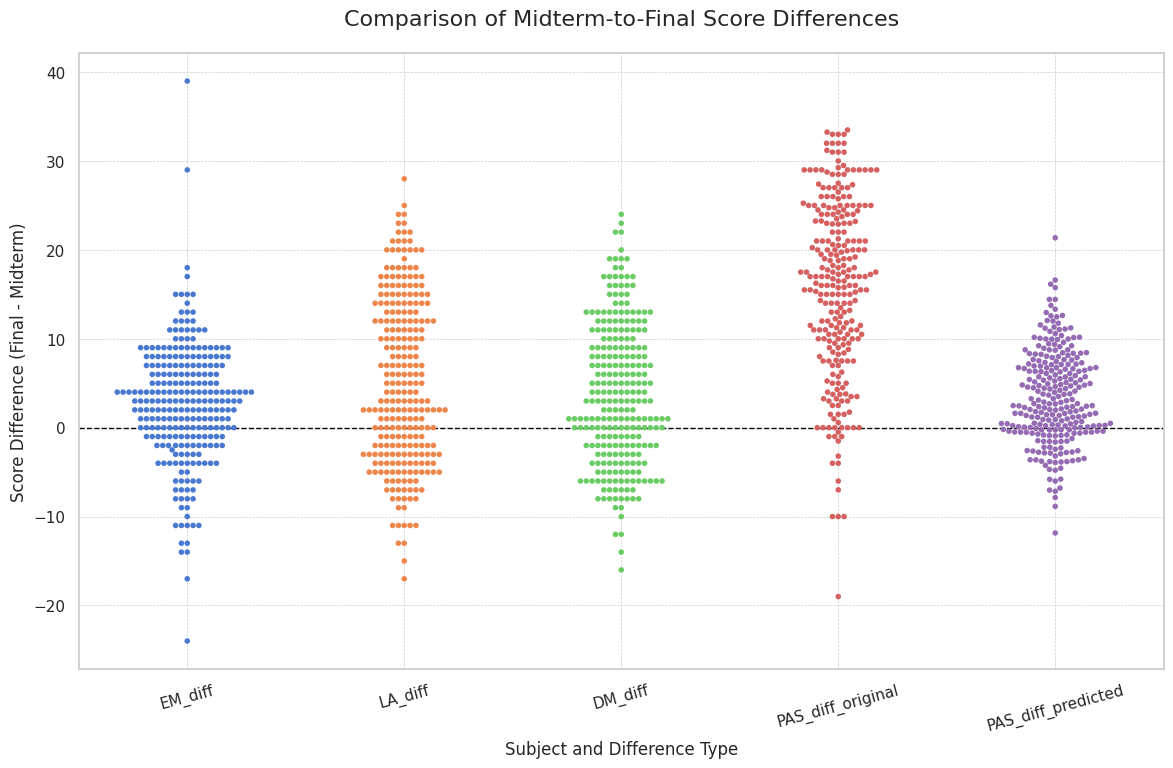

In [ ]:
# --- Visualization 4: Swarm Plot of Score Differences ---
print("Generating Swarm Plot of Score Differences...")

# Calculate the actual difference (Final - Midterm) for all courses
df['EM_diff'] = df['EM_final'] - df['EM_mid']
df['LA_diff'] = df['LA_final'] - df['LA_mid']
df['DM_diff'] = df['DM_final'] - df['DM_mid']
df['PAS_diff_original'] = df['PAS_final'] - df['PAS_mid']

# Calculate the predicted difference for PAS using the predicted final exam score
# 'predicted_final' is the unscaled numpy array from Step 4 of the main script
df['PAS_diff_predicted'] = predicted_final - df['PAS_mid']

# Select only the columns needed for this plot
diff_df = df[['EM_diff', 'LA_diff', 'DM_diff', 'PAS_diff_original', 'PAS_diff_predicted']]

# Melt the DataFrame to convert it from wide to long format, which is required by seaborn
diff_melted_df = diff_df.melt(var_name='Difference_Type', value_name='Score_Difference')

# Create the swarm plot
plt.figure(figsize=(14, 8))
sns.swarmplot(data=diff_melted_df, x='Difference_Type', y='Score_Difference', palette='muted', size=4)

# Add a horizontal line at y=0 to easily see score improvements vs. declines
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Comparison of Midterm-to-Final Score Differences', fontsize=16, pad=20)
plt.xlabel('Subject and Difference Type', fontsize=12)
plt.ylabel('Score Difference (Final - Midterm)', fontsize=12)
plt.xticks(rotation=15) # Rotate labels slightly for better readability
plt.grid(True, which='major', linestyle='--', linewidth='0.5')
plt.show()

